# <u> Hybrid CNN- RNN Model for Classification of Hyperspectral Satelite Images </u>
The following model uses hybrid CNN- RNN model for classification of each pixel to its corresponding classes. Further the code is developed to classify pixels in accordance with soft as well as hard classification techniques.<br>
1.) <b>HARD CLASSIFICATION </b>: A pixel strictly belongs to a single class. <br>
2.) <b>SOFT CLASSIFICATION </b>: A pixel may belong to more than one class based on its membership value. <br><br>

## <u> Importing necessary libraries and supporting files </u> 
<b>NOTE</b>- 'utils' is a supporting .py file which contains all the functions used in the notebook

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from keras.layers import Dense, Conv1D, Input, MaxPooling1D, Flatten, Dropout, LSTM
from keras import Sequential
from keras.utils import np_utils
from PIL import Image
import array
import sys
import os
from utils import hdr_read, ReadBilFile, thresholding, linear_stretch, display_save_image, extract_membership
seed = 7
np.random.seed(seed)


## <u> User Defined Parameters -  </u>
1.)<b>Header File</b>: Contains the information about the image file such as - Datatype, Number of Rows and Columns, Total number of bands etc <br>
2.)<b>Image File</b>: The information extracted from header file(with extension .hdr) is used to extract the hyperspectral image from the Image File <br>
3.)<b>Training Data</b>: Training data consists of the value of pixel from each band for a particular class <br> 
4.)<b>Epochs(model training)</b>: Number of iterations required to train the model. A lower value of epochs may lead to underfitting while a very high value may lead to overfitting of dataset, thus the choise of epochs is a crusial factor <br>
5.)<b>Selected class and Threshold value(soft classification))</b>: For the purpose of soft classification user needs to specify the threshold value (it acts as a limit, the pixels having values above that value are only classifies while pixels below it are assigned a NULL value) <br>

In [14]:
# User defined inputs
header_name = r"C:\Users\HP DV-6\Desktop\final_project\subfebformosat2.hdr"
file_name = r"C:\Users\HP DV-6\Desktop\final_project\subfebformosat2"

directory = r'C:\Users\HP DV-6\Desktop\final_project\Data'

epoch = '50'

threshold = '0.8'

category = 'Clay'

In [15]:
# The functions are used for the conversion of string to integer and float values
# Further the directory path is corrected 
epoch = int(epoch)
threshold = float(threshold)

directory = directory.replace(os.sep, '/')
directory = directory + '/'

header_name = header_name.replace(os.sep, '/')

file_name = file_name.replace(os.sep, '/')

In [16]:
row, col, bands, datatype = hdr_read(header_name)
x_test = ReadBilFile(file_name, bands, row*col)
x_test = x_test.reshape(row*col, bands, 1)
x_test = x_test / 2**8-1

y_test = np.zeros([row*col], dtype=np.uint8)   #Each pixel will belong to one class, so total no. of outputs=rows*columns

255 uint8


In [17]:
items = os.listdir(directory)
path = items
c_c = len(path)
c_l = {items[i] : i for i in range(0, len(items))}

values = []
clicks={}

for address in path:          # function to know the total number of clicks of each class
    with open(directory+address, "rb") as f:
        k = len(f.read())
        clicks[address] = (k // 2 // bands) if (k // 2 // bands) < 400 else (k // 2 // bands) // 4
        print('{} ==> {}'.format(address, clicks[address]))

for address in path:          # function (VALUES) returns the value of all the pixels (len(values) = total_clicks * 4)
    with open(directory+address, "rb") as f:
        b = array.array("H")
        b.fromfile(f, clicks[address]*bands)
        if sys.byteorder == "little":
            b.byteswap()
        for v in b:
            values.append(v)

Clay ==> 22
Dalforest ==> 23
EuFinal ==> 8
Grassland ==> 27
Water ==> 36
Wheat ==> 27


In [18]:
# Creation of training set
ll = (len(values))       # = total_clicks * 4
rex = ll // bands        # = total clicks


# Features
f_in = np.zeros([ll], dtype=np.uint8)
x = 0
for i in range(ll):
    f_in[x] = values[i]
    x += 1
    
x_train = f_in.reshape(rex, bands)
x_train = x_train / 2**8-1          # Normalising dataset to facilitate fast training

# Labels
y_train = np.zeros([rex], dtype=np.uint8)
mark = 0                              # Creating label file (Mark does bifurcation of each class)
for add in path:                      #  outer loop iterates over each class
    for i in range(clicks[add]):      # Inner loop assigns 1, 2, 3 based on c_1 dictionary to each pixel location
        y_train[mark+i] = c_l[add]
    mark = mark + clicks[add]

In [19]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
n_classes = c_c
y_test_new = np.zeros([row * col, c_c], dtype=np.uint8)


X = x_train.reshape(x_train.shape[0], bands, 1)

## <u> Structuring Model and defining model parameters
<b>KERAS FRAMEWORK</b> is used for the implementation of the model. The model consists of successive 1 dimensional Convolution and LSTM layers followed by Max Pooling layers. <br><br>
<b><u>Convolution Neural Network:</u></b> Convolutional Neural Networks, or CNNs were originally designed to map image data to an output variable.
They have proven so effective that they are the go-to method for any type of prediction problem involving image data as an input. More generally, CNNs work well with data that has a spatial relationship. <br>
<b><u>Recurrent Neural Network:</u></b> Recurrent Neural Networks, or RNNs, were designed to work with sequence prediction problems. RNNs in general and LSTMs in particular have received the most success when working with sequences of words and paragraphs, generally called natural language processing. However they can be used for variety of other aplications such as image processing as well

In [20]:
model = Sequential()

model.add(Conv1D(32, 4, activation='relu', padding='same', input_shape=(4, 1)))
model.add(LSTM(32, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(128))
model.add(Dense(n_classes, activation='sigmoid'))

### Model compilation and summary

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 4, 32)             160       
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 16)             4112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 64)             20736     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 16)             8208      
__________

### Training the model

In [22]:
history = model.fit(X, y_train, batch_size=10, epochs=epoch)

Epoch 1/50
143/143 [==============================] - 6s 45ms/step - loss: 1.7908 - acc: 0.2448
Epoch 2/50
143/143 [==============================] - 0s 2ms/step - loss: 1.7872 - acc: 0.2517
Epoch 3/50
143/143 [==============================] - 0s 2ms/step - loss: 1.7827 - acc: 0.2517
Epoch 4/50
143/143 [==============================] - 0s 2ms/step - loss: 1.7694 - acc: 0.2517
Epoch 5/50
143/143 [==============================] - 0s 2ms/step - loss: 1.7414 - acc: 0.2517
Epoch 6/50
143/143 [==============================] - 0s 2ms/step - loss: 1.7119 - acc: 0.2517
Epoch 7/50
143/143 [==============================] - 0s 2ms/step - loss: 1.7009 - acc: 0.2517
Epoch 8/50
143/143 [==============================] - ETA: 0s - loss: 1.6771 - acc: 0.261 - 0s 2ms/step - loss: 1.6779 - acc: 0.2517
Epoch 9/50
143/143 [==============================] - 0s 2ms/step - loss: 1.6418 - acc: 0.2517
Epoch 10/50
143/143 [==============================] - 0s 2ms/step - loss: 1.5920 - acc: 0.2517
Epoch 11/5

## <u> Hard Classification </u> 
In hard classification each pixel belongs to one category only

<IPython.core.display.Javascript object>


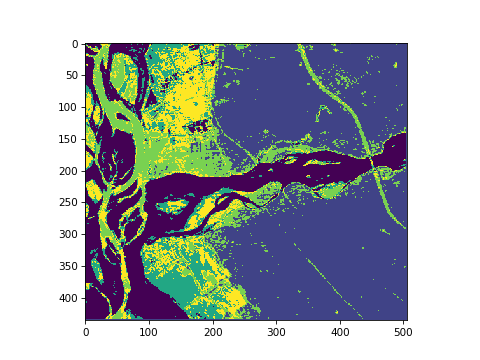

In [23]:
%matplotlib notebook
y_test_new = model.predict(x_test, batch_size=50)
y_test1 = np.argmax(y_test_new, axis=1)

display_save_image(y_test1, row, col, 'hard_classified')

## <u> Soft Classification </u> 
In soft classification a pixel may belong to more than one class based on their membership values.

Class number:  0


<IPython.core.display.Javascript object>


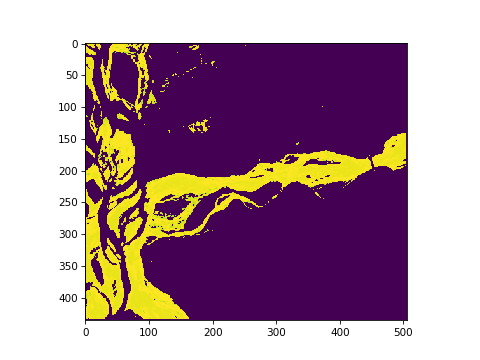

In [24]:
%matplotlib notebook
arg = c_l[category]
print('Class number: ', arg)
y1 = extract_membership(y_test_new, arg)
y1_th = thresholding(y1, threshold)
y1_std = linear_stretch(y1_th)

strg = category
name = 'soft'+ strg

display_save_image(y1_std, row, col, name)